In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [61]:
FLT = pd.read_excel('Jianing_FLT.xlsx') # Read the file into a DataFrame.
FLT.head()  # Display the first five rows of data.

,Date,FLT GEM Debiet influent even kant,FLT GEM Debiet influent oneven kant,FLT GEM Turb influent oneven,FLT GEM Turb influent even
0,2020-12-31 15:00:00,2965.654955,3483.320557,0.430411,0.751607
1,2020-12-31 16:00:00,2959.352060,3496.040518,0.522836,0.486650
2,2020-12-31 17:00:00,3009.247133,3062.499873,0.512069,0.452956
3,2020-12-31 18:00:00,3097.382712,1853.906166,0.450545,0.422725
4,2020-12-31 19:00:00,3014.303905,2485.336366,0.405494,0.410669


In [62]:
FLT['FLT GEM Turb influent oneven'].interpolate(method='linear',inplace=True)

In [63]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(FLT['Date'], FLT['FLT GEM Turb influent oneven'])
ax.set_xlabel('Time')
ax.set_ylabel('Turbidity')
ax.set_title('Turbidity oneven Time Series')

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/CH05_F01_peixeiro.png', dpi=300)


In [64]:
ADF_result = adfuller(FLT['FLT GEM Turb influent oneven']) # Run the ADF test

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.780097508622358
p-value: 0.0031176350310033745


In [65]:
Turbidity_oneven_diff = np.diff(FLT['FLT GEM Turb influent oneven'], n=1)

In [66]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(Turbidity_oneven_diff)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Turbidity')
ax.set_title('Turbidity_oneven_diff vs Time Series (differenced)')

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F05_peixeiro.png', dpi=300)


In [67]:
ADF_result = adfuller(Turbidity_oneven_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -33.030296057704874
p-value: 0.0


In [68]:
plot_acf(Turbidity_oneven_diff, lags=20);
plt.tight_layout()
plt.savefig('figures/CH05_F06_peixeiro.png', dpi=300)




In [69]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=26251)

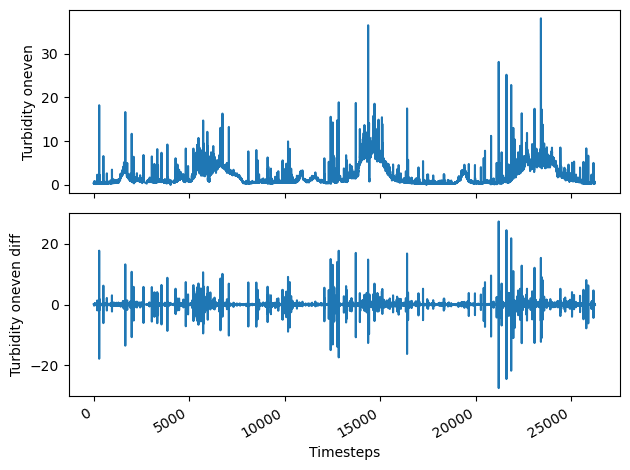

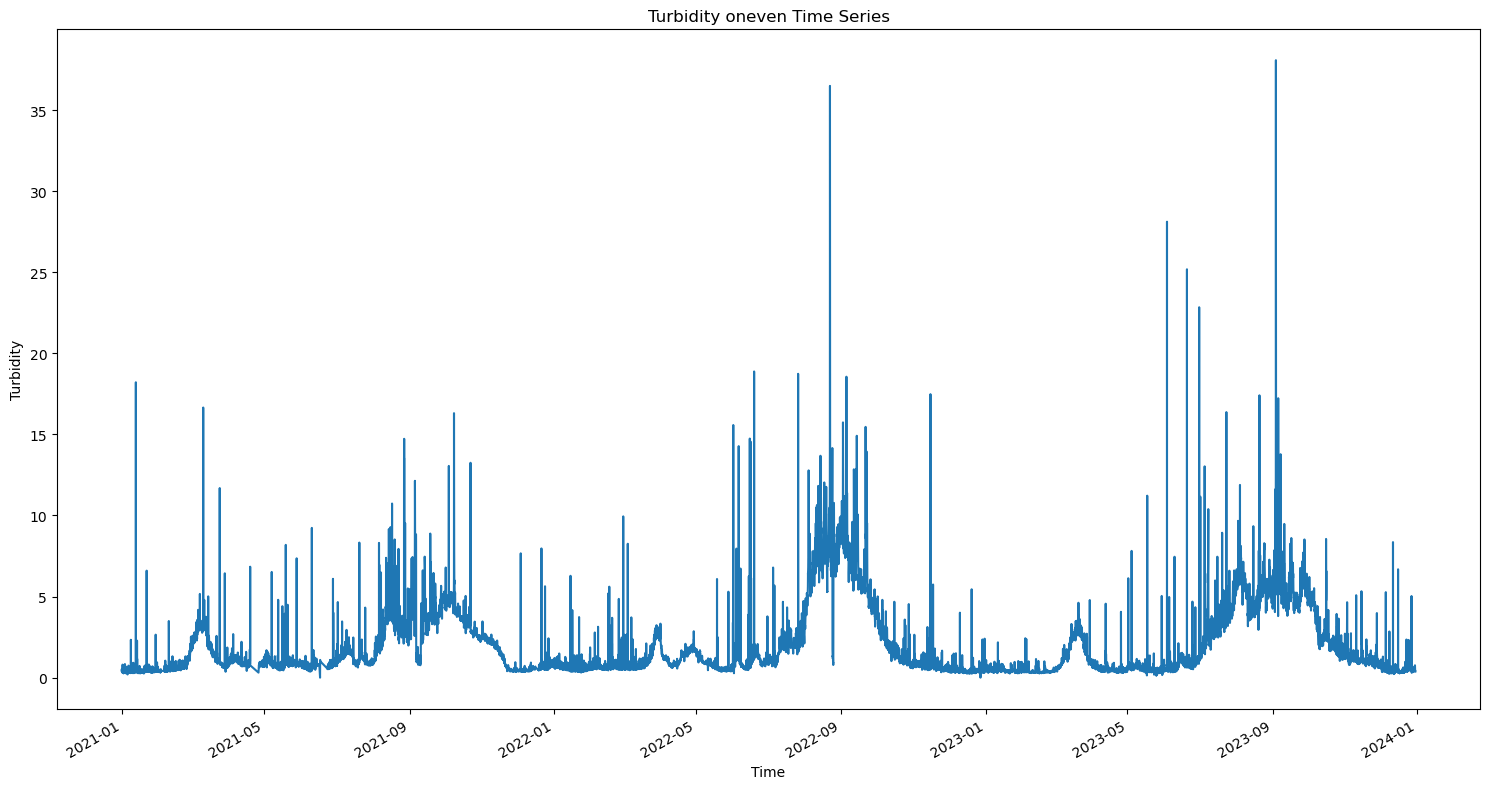

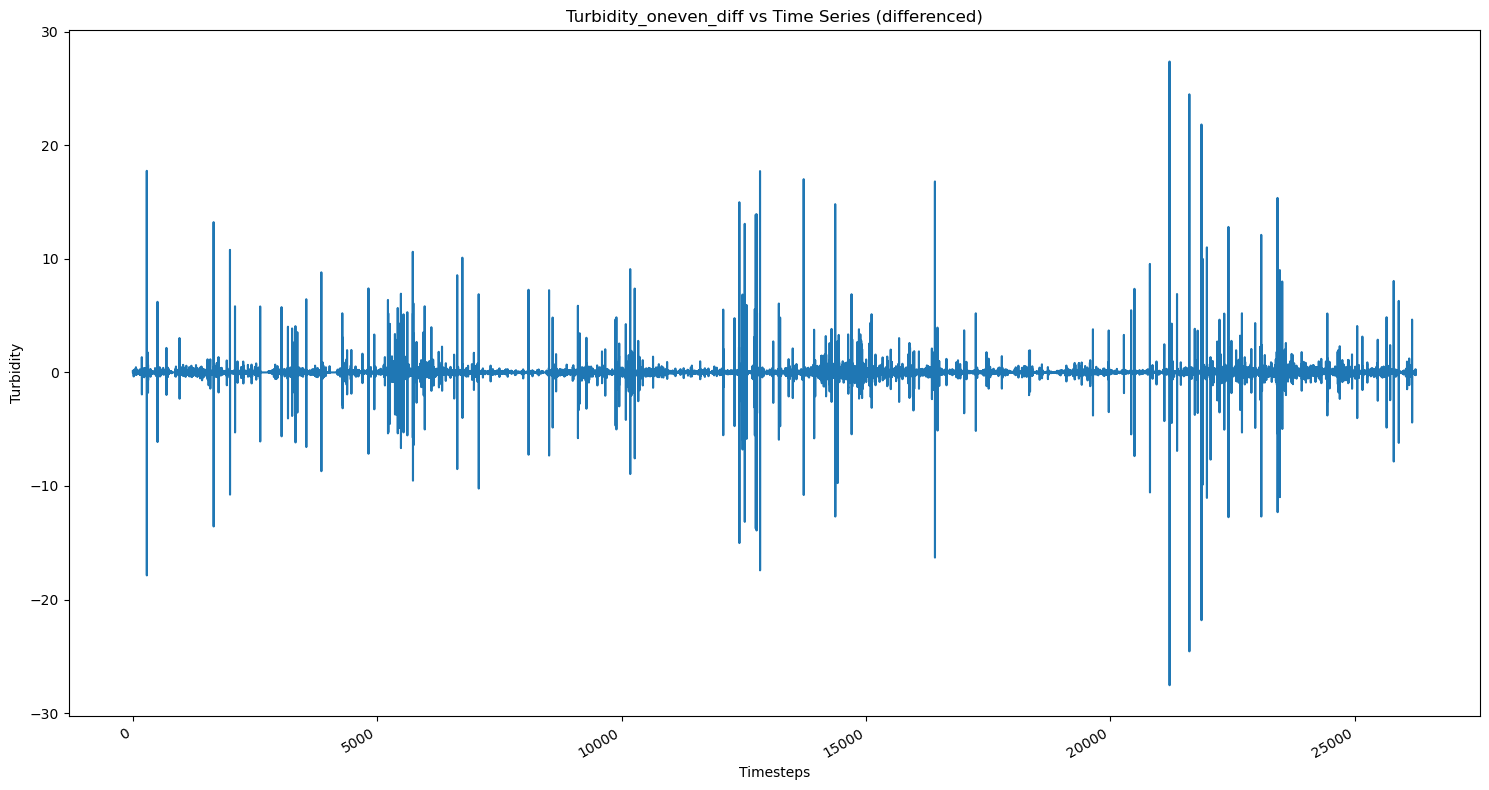

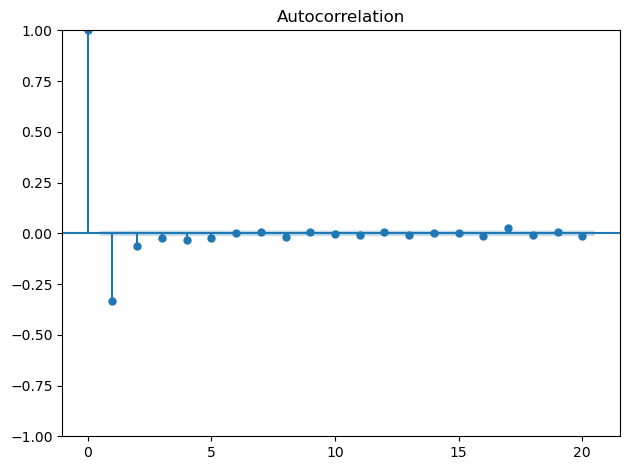

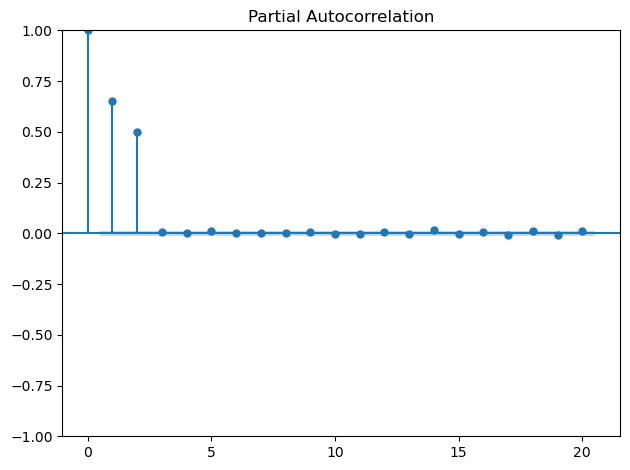

In [70]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F07_peixeiro.png', dpi=300)

plt.show()

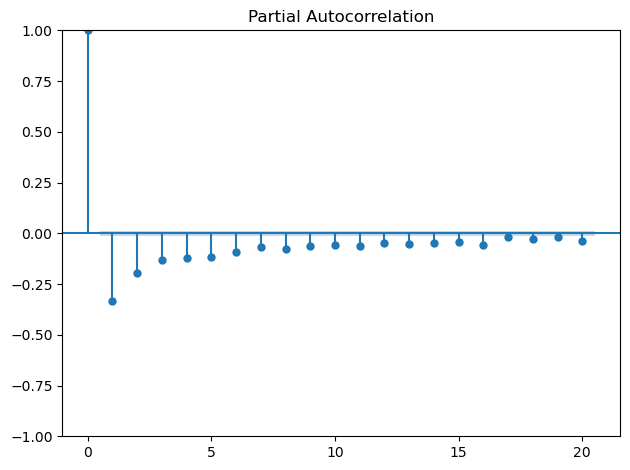

In [71]:
plot_pacf(Turbidity_oneven_diff, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F08_peixeiro.png', dpi=300)

plt.show()

In [72]:
FLT_diff = pd.DataFrame({'Turbidity_oneven_diff': Turbidity_oneven_diff})

train = FLT_diff[:23625]
test = FLT_diff[23625:]

print(len(train))
print(len(test))

23625
2625


In [73]:
print(train)

       Turbidity_oneven_diff
0                   0.092425
1                  -0.010766
2                  -0.061524
3                  -0.045050
4                  -0.018486
...                      ...
23620              -0.071748
23621              -0.055772
23622              -0.176135
23623              -0.211109
23624              -0.189959

[23625 rows x 1 columns]


In [74]:
print(test)

       Turbidity_oneven_diff
23625              -0.289157
23626              -0.048007
23627               0.028880
23628               0.295269
23629               0.439201
...                      ...
26245               0.026392
26246              -0.056996
26247               0.015745
26248               0.021359
26249              -0.055870

[2625 rows x 1 columns]


In [75]:
# Visualize the forecasting period for the differenced and original series.
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

# Original series
ax1.plot(FLT['FLT GEM Turb influent oneven'])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Turbidity oneven')
ax.axvspan(23626, 26251, color='#808080', alpha=0.2)


# Differenced series
ax2.plot(FLT_diff['Turbidity_oneven_diff'])
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Turbidity oneven diff')
ax.axvspan(23625, 26249, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F07_peixeiro.png', dpi=300)

In [76]:
def rolling_forecast(FLT: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(FLT[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = FLT[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value[:horizon]
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(FLT[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR[:horizon]

In [77]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(FLT_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(FLT_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(FLT_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,Turbidity_oneven_diff,pred_mean,pred_last_value,pred_AR
23625,-0.289157,0.000170,-0.189959,0.156223
23626,-0.048007,0.000158,-0.289157,0.197653
23627,0.028880,0.000156,-0.048007,0.117166
23628,0.295269,0.000157,0.028880,0.037534
23629,0.439201,0.000170,0.295269,-0.126258


In [78]:
fig, ax = plt.subplots()

ax.plot(FLT_diff['Turbidity_oneven_diff'])
ax.plot(test['Turbidity_oneven_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Turbidity oneven diff')

ax.axvspan(23625, 26249, color='#808080', alpha=0.2)

ax.set_xlim(20000, 26250)


fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F08_peixeiro.png', dpi=300)

In [79]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['Turbidity_oneven_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['Turbidity_oneven_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['Turbidity_oneven_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

0.21442342967710024 0.5737488140770715 0.1804717024014294


In [80]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [81]:
FLT['pred_Turbidity'] = pd.Series()
FLT['pred_Turbidity'][23626:] = FLT['FLT GEM Turb influent oneven'].iloc[23626] + test['pred_AR'].cumsum()

In [82]:
fig, ax = plt.subplots()

ax.plot(FLT['FLT GEM Turb influent oneven'])
ax.plot(FLT['FLT GEM Turb influent oneven'], 'b-', label='actual')
ax.plot(FLT['pred_Turbidity'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')


ax.axvspan(23626, 26251, color='#808080', alpha=0.2)

ax.set_xlim(23000, 26251)



fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F11_peixeiro.png', dpi=300)

In [83]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(FLT['FLT GEM Turb influent oneven'].iloc[23626:], FLT['pred_Turbidity'].iloc[23626:])

print(mae_MA_undiff)

4.7528652697960005
